In [1]:
import os
import re

import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import scipy as sp
import sklearn as sk
import time
from dypac import Dypac
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr

## load data per subject

In [2]:
subjects = [114419,108828,180129,118932]
#130316,131722,151223,151526,156637,178950,201111 (have locally but not extracted)
# Define the path to 4D images
paths = []
for sub in subjects:
    paths.append('/mnt/c/Users/liz/Desktop/course-materials-2020/fMRI_HCP/HCP_RS/{}/MNINonLinear/Results/rfMRI_REST2_LR/rfMRI_REST2_LR_hp2000_clean.nii.gz'.format(sub))

In [3]:
#Take the first time point of the first subject
img = image.index_img(paths[0],0)

#plotting.plot_glass_brain(img)


## Explore the data

In [4]:
print(type(img))
print(img.shape)
data = img.get_fdata()
print(type(data))
print(data.shape)

<class 'nibabel.nifti1.Nifti1Image'>
(91, 109, 91)
<class 'numpy.ndarray'>
(91, 109, 91)


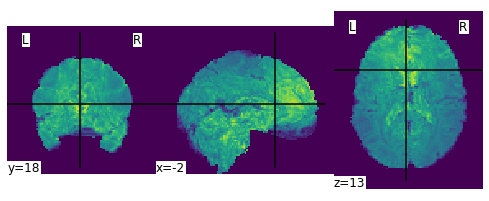

In [5]:
#from nilearn import plotting
plotting.plot_img(img)

In [6]:
#all time points of this subject
img_all = nib.load(paths[0])
type(img_all)

nibabel.nifti1.Nifti1Image

In [7]:
data = img_all.get_fdata()
print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(91, 109, 91, 1200)


## Mean image of all the time points for a specific subject


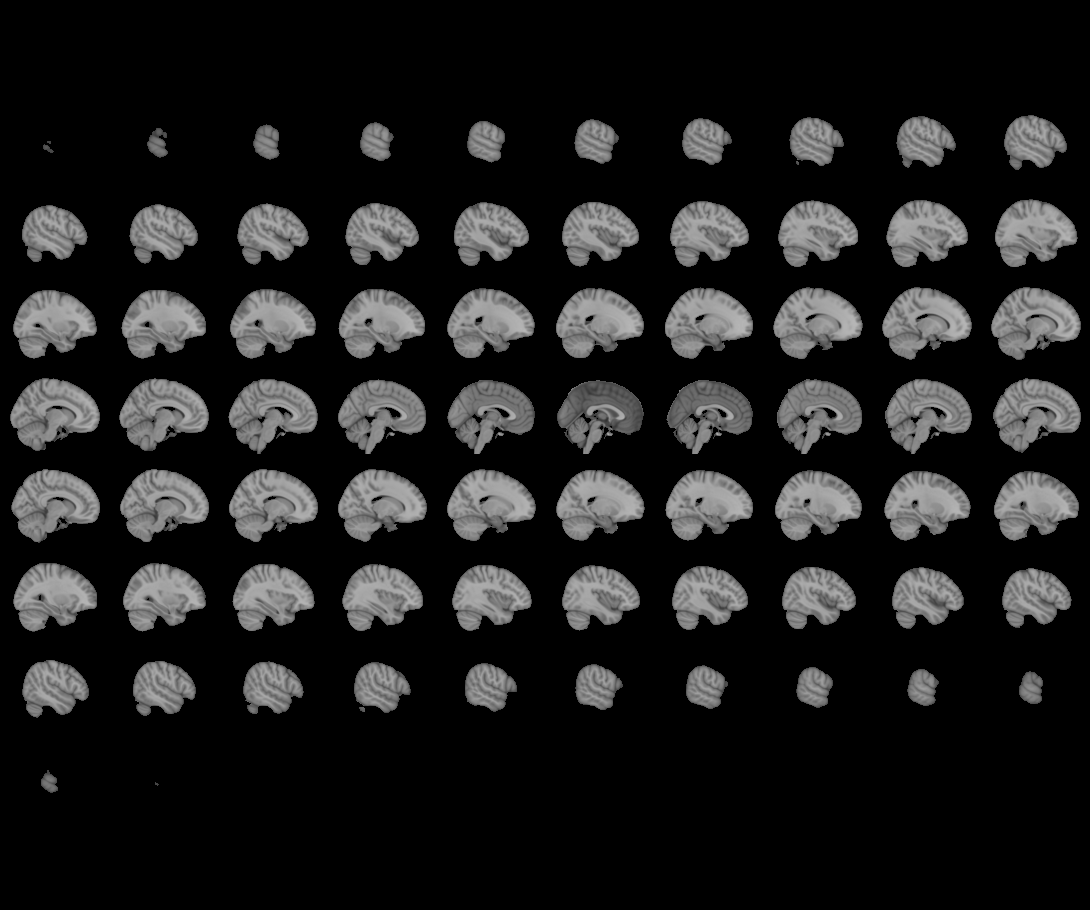
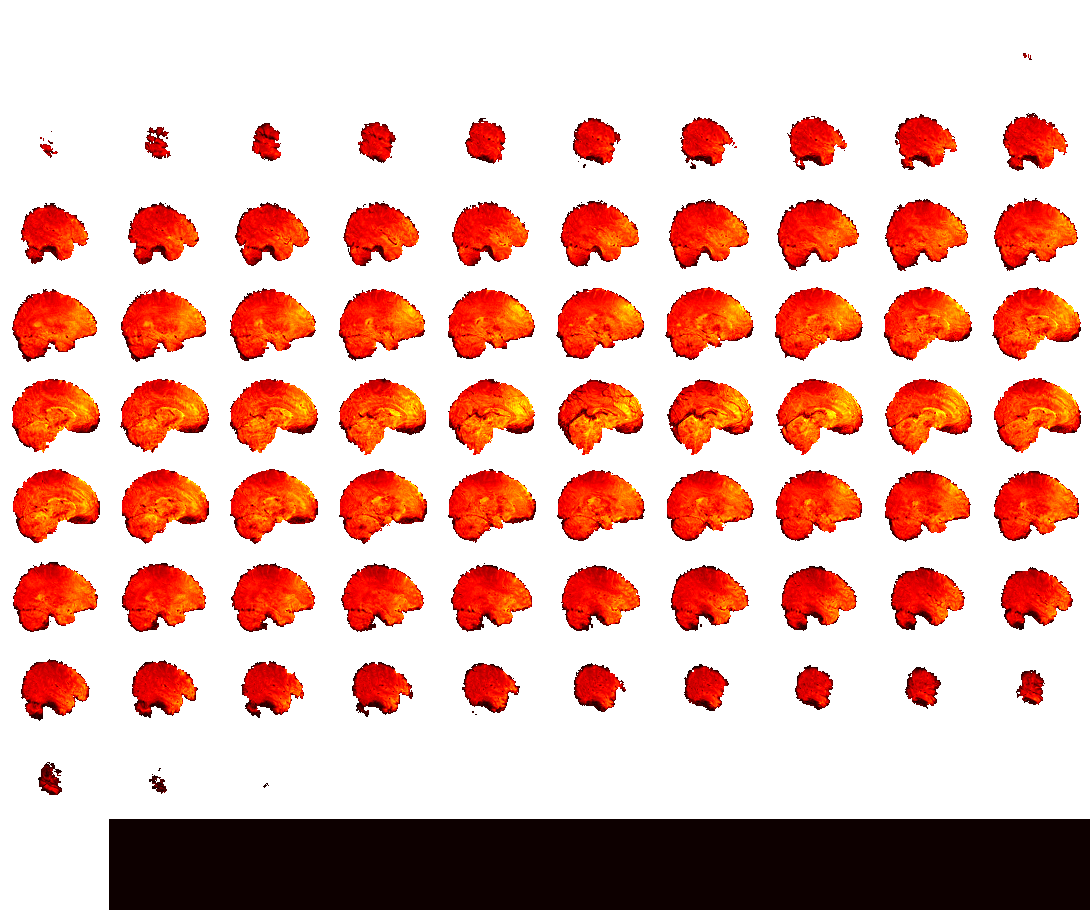

In [8]:
from nilearn.image import mean_img

plotting.view_img(mean_img(img_all))

## Convert the fMRI volumes to a data matrix

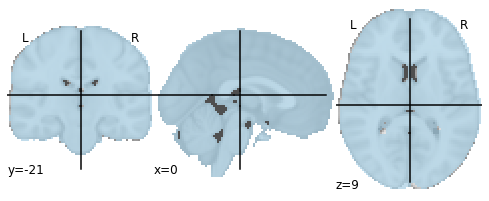

In [9]:
brain_mask = datasets.load_mni152_brain_mask()
plotting.plot_roi(brain_mask, cmap='Paired')

In [10]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=brain_mask, standardize=True)
masker

NiftiMasker(detrend=False, dtype=None, high_pass=None, low_pass=None,
            mask_args=None,
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7ff2e1e11a90>,
            mask_strategy='background', memory=Memory(location=None),
            memory_level=1, reports=True, sample_mask=None, sessions=None,
            smoothing_fwhm=None, standardize=True, t_r=None, target_affine=None,
            target_shape=None, verbose=0)

In [11]:
# We give the masker a filename and retrieve a 2D array ready
# for machine learning with scikit-learn 
fmri_masked = masker.fit_transform(img_all)
print(fmri_masked)

[[ 1.6912954   0.5321526  -0.38654518 ... -0.16462891  0.
   0.        ]
 [-1.7817501  -2.214099    0.16362797 ...  0.7082406   0.
   0.        ]
 [-0.18630356  0.83094585 -0.20455319 ... -1.0491356   0.
   0.        ]
 ...
 [ 1.0566881  -1.249341    1.4711659  ... -0.6042501   0.
   0.        ]
 [ 0.03718227  0.14674388 -1.0458902  ... -0.517462    0.
   0.        ]
 [-0.03596364  0.1676093  -0.3918595  ... -0.85961765  0.
   0.        ]]


In [12]:
print(fmri_masked.shape)

(1200, 228453)


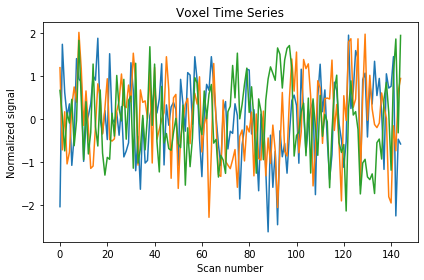

In [13]:
import matplotlib.pyplot as plt
plt.plot(fmri_masked[5:150, :3])

plt.title('Voxel Time Series')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()

## Extracting signals from a brain parcellation

In [14]:
multiscale = datasets.fetch_atlas_basc_multiscale_2015(resume=True)
print('Atlas ROIs are located at: %s' % multiscale.scale064)

Atlas ROIs are located at: /home/lizakson/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz


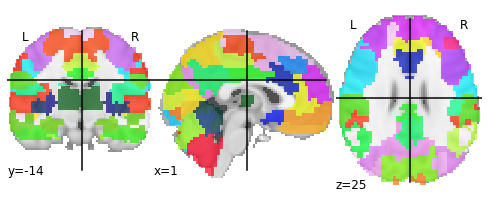

In [15]:
plotting.plot_roi(multiscale.scale064)

In [16]:
from nilearn.input_data import NiftiLabelsMasker
label_masker = NiftiLabelsMasker(labels_img=multiscale.scale064, standardize=True)
label_masker

NiftiLabelsMasker(background_label=0, detrend=False, dtype=None, high_pass=None,
                  labels_img='/home/lizakson/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz',
                  low_pass=None, mask_img=None, memory=Memory(location=None),
                  memory_level=1, resampling_target='data', smoothing_fwhm=None,
                  standardize=True, strategy='mean', t_r=None, verbose=0)

In [17]:
fmri_matrix = label_masker.fit_transform(img_all)
print(fmri_matrix)

[[-1.6055675   0.87014824  0.5493441  ...  1.2578725  -0.360706
  -0.33377725]
 [ 0.6811349  -0.19353443  0.47204468 ...  0.06906559 -0.7288254
  -0.53814286]
 [-1.6230325   1.5420741  -1.3628818  ... -0.27619368 -0.60027033
   0.9773046 ]
 ...
 [-1.101204    0.06832581 -0.40355092 ... -1.5996304  -1.1544461
  -0.44362003]
 [-0.18593971  0.00564768 -1.0808678  ...  0.30413574 -0.76389545
  -0.35415396]
 [-1.2556235  -1.2825762  -1.4685731  ... -1.0136027  -0.97217077
  -0.32336447]]


In [18]:
print(fmri_matrix.shape)

(1200, 64)


## Compute and display a correlation matrix

In [19]:
from nilearn import connectome
correlation_measure = connectome.ConnectivityMeasure(kind='correlation')
correlation_measure

ConnectivityMeasure(cov_estimator=LedoitWolf(assume_centered=False,
                                             block_size=1000,
                                             store_precision=False),
                    discard_diagonal=False, kind='correlation',
                    vectorize=False)

In [20]:
correlation_matrix = correlation_measure.fit_transform([fmri_matrix])
correlation_matrix

array([[[ 1.        ,  0.3370454 ,  0.2584265 , ...,  0.2680935 ,
          0.3687151 ,  0.19190364],
        [ 0.3370454 ,  1.        ,  0.20574935, ...,  0.4861176 ,
          0.20794025, -0.08573951],
        [ 0.2584265 ,  0.20574935,  1.        , ...,  0.18726341,
          0.2506534 ,  0.17216758],
        ...,
        [ 0.2680935 ,  0.4861176 ,  0.18726341, ...,  1.        ,
          0.31949165, -0.03173215],
        [ 0.3687151 ,  0.20794025,  0.2506534 , ...,  0.31949165,
          1.        ,  0.24445029],
        [ 0.19190364, -0.08573951,  0.17216758, ..., -0.03173215,
          0.24445029,  1.        ]]], dtype=float32)

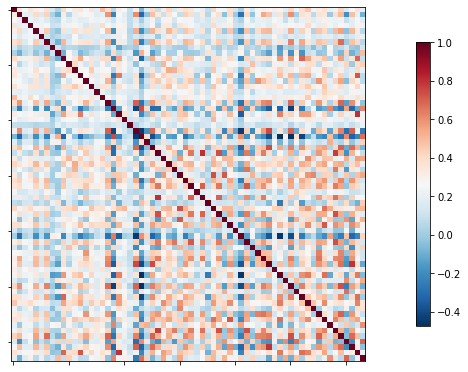

In [21]:
import numpy as np

correlation_matrix = correlation_matrix[0]
# Mask the main diagonal for visualization:
# np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix)

In [22]:
vectorized_correlation = connectome.ConnectivityMeasure(kind='correlation',
                                                        vectorize=True, discard_diagonal=True)
clean_vectorized_correlation = vectorized_correlation.fit_transform([correlation_matrix])[0]
clean_vectorized_correlation.shape  # Exercise: Why is this value not 64 * 64 ?

(2016,)

## Interactive plot of the connectivity matrix

In [23]:
coords_forPlot = plotting.find_parcellation_cut_coords(multiscale.scale064)
coords_forPlot

array([[-24.94559099,   1.21763602,   1.27579737],
       [-43.35348837,  -8.99534884,  -2.32093023],
       [ -8.625     , -45.04375   ,  -8.6375    ],
       [-12.496     , -18.88      ,   6.56      ],
       [-25.77372263, -54.44160584, -51.16058394],
       [-15.13407821, -45.74022346, -23.63687151],
       [ -6.79787234,  21.32446809,  28.28723404],
       [ -9.86029412,  11.77205882, -11.46323529],
       [-39.81991525,   4.38347458, -40.20550847],
       [ -7.79617834,  31.08280255,  39.78980892],
       [ 32.67451382, -68.4616172 , -38.41146366],
       [-29.88780488, -78.52195122, -21.94634146],
       [-45.36752137,  20.36324786,  21.65811966],
       [-57.32051282,  -4.41666667,  28.94871795],
       [-24.19726027, -70.24657534, -53.92054795],
       [-28.64705882, -47.37647059, -10.82352941],
       [-14.27329193,   9.98447205,   9.85093168],
       [-47.3047619 ,  -3.96190476,  11.96190476],
       [ -7.71028037, -49.58878505,  32.29906542],
       [-49.69889503, -56.97651

In [24]:
view = plotting.view_connectome(correlation_matrix, node_coords = coords_forPlot)
view